In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from itertools import combinations

import geopandas as gpd
from shapely import wkt

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

demographic and housing:\
https://data.census.gov/table/ACSDP5Y2022.DP05?q=DP05&g=040XX00US36$8600000

eocnomic characteristics:\
https://data.census.gov/table/ACSDP5Y2022.DP03?q=DP03&g=040XX00US36$8600000

social characteristics\
https://data.census.gov/table?q=DP02&g=040XX00US36$8600000

In [2]:
social = pd.read_csv("../../data/raw/ACSDP5Y2022.DP02-Data.csv")
social = social.iloc[1:,[0,1,2,36,136,144]]
social['zipcode'] = social.NAME.astype(str).apply(lambda x: x[5:])
social['zipcode'] = social['zipcode'].astype(int)
social = social[(social['zipcode'] >= 11201) & (social['zipcode'] <= 11256)]
social = social.drop(['NAME'], axis=1)

# 25+bh means Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher
# total_noninsti_dis means Estimate!!DISABILITY STATUS OF THE CIVILIAN NONINSTITUTIONALIZED POPULATION!!Total Civilian Noninstitutionalized Population!!With a disability
social.columns = ['GEO_ID', 'households_num', 'pop_num', '25+bh', 'total_noninsti_dis', 'zipcode']
social = social.reset_index().iloc[:,1:]
social.head(3)

,GEO_ID,households_num,pop_num,25+bh,total_noninsti_dis,zipcode
0,860Z200US11201,32227,66166,40605,5634,11201
1,860Z200US11203,29411,76434,14873,8094,11203
2,860Z200US11204,25118,80301,15223,6710,11204


In [3]:
eco = pd.read_csv("../../data/raw/ACSDP5Y2022.DP03-Data.csv"); eco.head(3)
eco = eco.iloc[1:,[0,1,36,42,44,124,126,176]]
eco['zipcode'] = eco.NAME.astype(str).apply(lambda x: x[5:])
eco['zipcode'] = eco['zipcode'].astype(int)
eco = eco[(eco['zipcode'] >= 11201) & (eco['zipcode'] <= 11256)]
eco = eco.drop(['NAME'], axis=1)

# total_commute16+ means Estimate!!COMMUTING TO WORK!!Workers 16 years and over
# commute_pub16+ means Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab)
# commute_walk16+ means Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Walked
# med_hh_inc means Estimate!!INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
# mean_hh_inc means Estimate!!INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Total households!!Mean household income (dollars)
# per_cap_inc means Estimate!!INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Per capita income (dollars)
eco.columns = ['GEO_ID', 'total_commute16+', 'commute_pub_16+', 'commute_walk_16+', 'med_hh_inc', 'mean_hh_inc', 'per_cap_inc', 'zipcode']
eco = eco.reset_index().iloc[:,2:]
eco.head(3)

,total_commute16+,commute_pub_16+,commute_walk_16+,med_hh_inc,mean_hh_inc,per_cap_inc,zipcode
0,40537,20026,4034,163310,232020,108933,11201
1,35916,20482,2185,68006,89068,34492,11203
2,31103,13156,4499,64172,83981,25404,11204


In [4]:
dem = pd.read_csv("../../data/raw/ACSDP5Y2022.DP05-Data.csv"); dem.head(3)
dem = dem.iloc[1:,[0,1,46]]
dem['zipcode'] = dem.NAME.astype(str).apply(lambda x: x[5:])
dem['zipcode'] = dem['zipcode'].astype(int)
dem = dem[(dem['zipcode'] >= 11201) & (dem['zipcode'] <= 11256)]
dem = dem.drop(['NAME'], axis=1)

# total_62+ Estimate!!SEX AND AGE!!Total population!!62 years and over
dem.columns = ['GEO_ID', 'total_62+','zipcode']
dem = dem.reset_index().iloc[:,2:]
dem.head(3)

,total_62+,zipcode
0,10035,11201
1,18713,11203
2,14287,11204


In [5]:
# combining ACS 5-Year data together
acs = social.merge(eco, on='zipcode', how='outer')
acs = acs.merge(dem, on='zipcode', how='outer')
acs.head(3)

,GEO_ID,households_num,pop_num,25+bh,total_noninsti_dis,zipcode,total_commute16+,commute_pub_16+,commute_walk_16+,med_hh_inc,mean_hh_inc,per_cap_inc,total_62+
0,860Z200US11201,32227,66166,40605,5634,11201,40537,20026,4034,163310,232020,108933,10035
1,860Z200US11203,29411,76434,14873,8094,11203,35916,20482,2185,68006,89068,34492,18713
2,860Z200US11204,25118,80301,15223,6710,11204,31103,13156,4499,64172,83981,25404,14287


Merge with df

In [6]:
df = pd.read_csv("../../data/processed_data/cleaned_integrated.csv") 
df = df.drop(df.index[df.zipcode == 11231][1])

print('zipcode include in df not in acs', set(df.zipcode.unique())-set(acs.zipcode.unique()))
df = df.merge(acs, on='zipcode', how='left')

int_cols = ['zipcode', 'state_fips', 'county_fips', 'lights_number','pop_num','25+bh',
                'total_noninsti_dis','total_commute16+','commute_pub_16+','commute_walk_16+','total_62+']
float_cols = ['med_hh_inc','mean_hh_inc','per_cap_inc']

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df = df.drop('population', axis=1) # this population in zipcode file is not up to date

# street_pos_ratio means combination of good and fair ratio
df['street_pos_ratio'] = df.street_good_ratio + df.street_fair_ratio

df['pop_den_mile'] = df.pop_num / df.area_mile
df.head(3)

zipcode include in df not in acs {11251.0}


,zipcode,po_name,area,state_fips,county_fips,geometry,lights_number,area_mile,light_density_mile,business_landuse,public_landuse,residential_landuse,total_landuse_area,business_ratio,public_ratio,residential_ratio,sidewalk_length,sidewalk_area,street_fair_ft,street_good_ft,street_nr_ft,street_poor_ft,street_length_ft,street_fair_ratio,street_good_ratio,street_nr_ratio,street_poor_ratio,arrest_count,jan_arrests,feb_arrests,mar_arrests,apr_arrests,may_arrests,jun_arrests,jul_arrests,aug_arrests,sep_arrests,oct_arrests,nov_arrests,dec_arrests,pop_dens_mile,sidewalk_area_mile,sidewalk_density,GEO_ID,households_num,pop_num,25+bh,total_noninsti_dis,total_commute16+,commute_pub_16+,commute_walk_16+,med_hh_inc,mean_hh_inc,per_cap_inc,total_62+,street_pos_ratio,pop_den_mile
0,11213,Brooklyn,2.963100e+07,36,47,POLYGON ((1001613.7129640579 186926.4395172149...,646,1.062866,607.790615,5327324.0,3480718.0,25284240.0,34092282.0,0.156262,0.102097,0.741641,517941.119336,3.404947e+06,20450.328412,74077.364992,0.00000,171.353421,94699.046825,0.215951,0.782240,0.000000,0.001809,2568.0,205.0,197.0,204.0,229.0,236.0,220.0,203.0,199.0,223.0,258.0,201.0,193.0,58733.648459,0.122136,0.114912,860Z200US11213,26281,67382,14638,8571,29101,16600,2723,54211.0,84408.0,32775.0,11155,0.998191,63396.512678
1,11212,Brooklyn,4.197210e+07,36,47,"POLYGON ((1011174.275535807 183696.33770971, 1...",728,1.505542,483.546766,9686094.0,5368412.0,28256031.0,43310537.0,0.223643,0.123952,0.652405,804360.335036,5.094083e+06,42740.061035,135857.883777,2063.14967,748.383281,181409.477763,0.235600,0.748902,0.011373,0.004125,2961.0,287.0,241.0,275.0,228.0,290.0,227.0,293.0,293.0,196.0,238.0,202.0,191.0,55704.853166,0.182725,0.121368,860Z200US11212,32091,77485,9109,12591,29233,19090,1851,35840.0,53831.0,21502.0,15580,0.984502,51466.512622
2,11225,Brooklyn,2.369863e+07,36,47,POLYGON ((995908.3654508889 183617.61280155182...,490,0.850071,576.422178,7868115.0,2554369.0,21182554.0,31605038.0,0.248951,0.080822,0.670227,401025.097033,2.462233e+06,27581.352686,58257.349875,0.00000,434.510199,86273.212760,0.319698,0.675266,0.000000,0.005036,1427.0,111.0,101.0,114.0,114.0,123.0,130.0,108.0,156.0,136.0,128.0,113.0,93.0,66496.768308,0.088320,0.103898,860Z200US11225,24873,58082,20399,5582,30607,17763,1612,82716.0,107973.0,46442.0,10779,0.994964,68326.026445


In [7]:
df.columns

Index(['zipcode', 'po_name', 'area', 'state_fips', 'county_fips', 'geometry',
       'lights_number', 'area_mile', 'light_density_mile', 'business_landuse',
       'public_landuse', 'residential_landuse', 'total_landuse_area',
       'business_ratio', 'public_ratio', 'residential_ratio',
       'sidewalk_length', 'sidewalk_area', 'street_fair_ft', 'street_good_ft',
       'street_nr_ft', 'street_poor_ft', 'street_length_ft',
       'street_fair_ratio', 'street_good_ratio', 'street_nr_ratio',
       'street_poor_ratio', 'arrest_count', 'jan_arrests', 'feb_arrests',
       'mar_arrests', 'apr_arrests', 'may_arrests', 'jun_arrests',
       'jul_arrests', 'aug_arrests', 'sep_arrests', 'oct_arrests',
       'nov_arrests', 'dec_arrests', 'pop_dens_mile', 'sidewalk_area_mile',
       'sidewalk_density', 'GEO_ID', 'households_num', 'pop_num', '25+bh',
       'total_noninsti_dis', 'total_commute16+', 'commute_pub_16+',
       'commute_walk_16+', 'med_hh_inc', 'mean_hh_inc', 'per_cap_inc',
     

## Correlations

In [8]:
corr_df = df[['light_density_mile', 'business_ratio', 'public_ratio', 'residential_ratio',
       'sidewalk_length', 'sidewalk_density',
       'street_pos_ratio', 'street_nr_ratio','street_poor_ratio', 'arrest_count', 'pop_dens_mile', 
       ]]

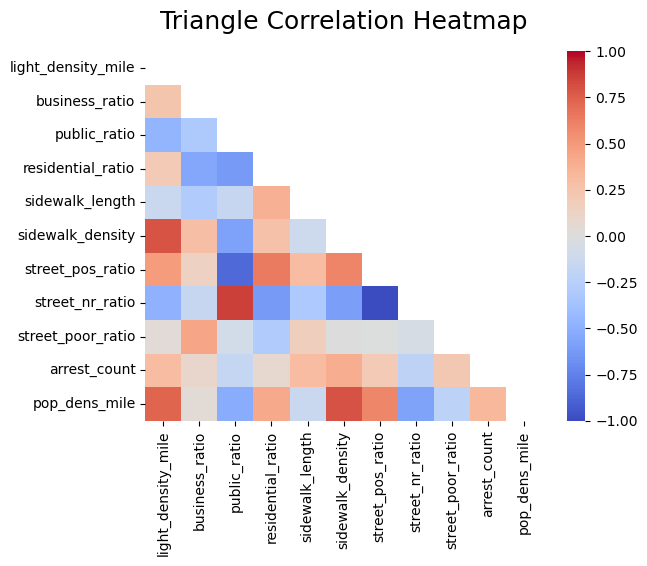

In [9]:
plt.figure()
mask = np.triu(np.ones_like(corr_df.corr(), dtype=bool))
heatmap = sns.heatmap(corr_df.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='coolwarm')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.savefig('../../results/triangle_correlation_heatmap.png', dpi=300, bbox_inches='tight')

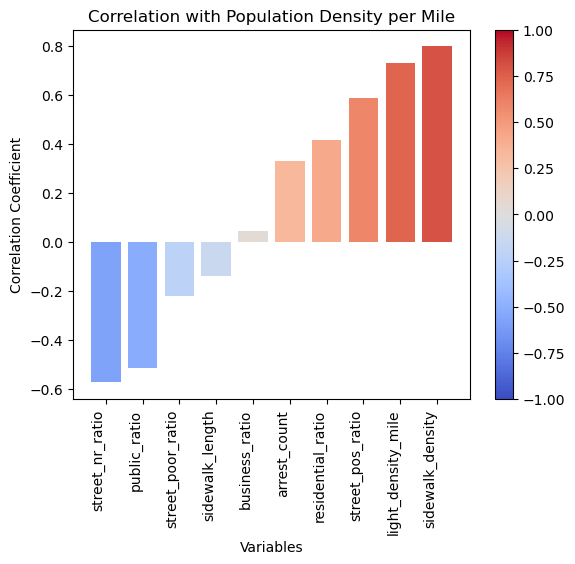

In [10]:
correlations = corr_df.corr()['pop_dens_mile'].drop('pop_dens_mile')
correlations.sort_values(inplace=True)

cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=-1, vmax=1)

colors = cmap(norm(correlations.values))

plt.figure()
plt.bar(correlations.index, correlations, color=colors)
plt.title('Correlation with Population Density per Mile')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical')
plt.xticks(rotation=90, ha='right')
plt.savefig("../../results/corr_pop_bar.png", dpi=300, bbox_inches='tight')
plt.show()

## Cluster
In this study, using cluster analysis can help us better understand the differences and similarities in sidewalk safety across different areas.

- Discovering Patterns and Associations: By clustering the dataset, we can reveal which variables (such as light density, crime rates, and sidewalk width) have the greatest impact on pedestrian safety. This helps in identifying the factors that are most predictive of unsafe areas.

- Distinguishing Regional Characteristics: Clustering can help differentiate pedestrian safety characteristics in different postal code areas, such as those with high crime rates, poor street conditions, or high commercial land use density, which may display different safety dynamics.

- Optimizing Resource Allocation: By identifying areas that need the most urgent intervention (for example, areas with high crime rates or poor street conditions), cluster analysis can help policymakers and urban planners allocate resources more effectively, such as improving lighting or increasing surveillance.

- Strategy Formulation and Planning: Based on the results of clustering, specific strategies can be developed for particular areas, such as increasing police presence in areas with high crime rates or adding safety facilities in densely populated areas.

- Comparison and Benchmarking: Using clustering, safety benchmarks can be created for different areas. This aids in assessing the effectiveness of safety measures over time and comparing improvements across various regions.








In our research, we employ cluster analysis to identify characteristics of pedestrian sidewalk safety across different areas of Brooklyn. The key clustering variables considered include: light_density, which reflects the extent of street lighting coverage; densities of different land uses (business_ratio, public_ratio, residential_ratio), helping us understand the impact of commercial, public, and residential areas on pedestrian traffic and safety; street condition ratios (street_fair_ratio, street_good_ratio, street_nr_ratio, street_poor_ratio), offering a direct overview of street maintenance conditions; crime data such as total arrests (arrest_count) and monthly arrest counts, which reflect the relationship between criminal activity and pedestrian safety; and the physical conditions of sidewalks and streets (sidewalk_area, street_length_ft), assessing the quality and availability of walking spaces. By clustering these key variables, we can reveal which factors most significantly impact pedestrian safety, thereby providing data-driven support for urban planning and policy-making.

Feature selection and Standardization

In [11]:
# Feature selection
features = ['light_density_mile', 'business_ratio', 'public_ratio', 'residential_ratio',
       'sidewalk_density',
       'street_pos_ratio', 'arrest_count', 'pop_dens_mile', 
       ]

# Standardizing the data
scaler = StandardScaler()
features_df = df[features]
features_scaled = scaler.fit_transform(features_df)

### K-means

In [12]:
# Choosing the number of clusters with the silhouette score
range_n_clusters = list(range(2, 11))  # typically starting from 2 up to a reasonable limit
silhouettes_km = []

# Evaluate silhouette scores for different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouettes_km.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

# Identify the best number of clusters based on the maximum silhouette score
best_k = range_n_clusters[silhouettes_km.index(max(silhouettes_km))]
print(f"Best number of clusters for k-means: {best_k}")

For n_clusters = 2, the average silhouette_score is: 0.6753269319374462
For n_clusters = 3, the average silhouette_score is: 0.24670818523997154
For n_clusters = 4, the average silhouette_score is: 0.26306978498113953
For n_clusters = 5, the average silhouette_score is: 0.26350097424816743
For n_clusters = 6, the average silhouette_score is: 0.2633515866654748
For n_clusters = 7, the average silhouette_score is: 0.27316349759630815
For n_clusters = 8, the average silhouette_score is: 0.29141182674720145
For n_clusters = 9, the average silhouette_score is: 0.2988287109834569
For n_clusters = 10, the average silhouette_score is: 0.27436256530939496
Best number of clusters for k-means: 2


In [13]:
# Ensure 'geometry' is properly formatted and convert to GeoDataFrame
if isinstance(df['geometry'].iloc[0], str):
    df['geometry'] = df['geometry'].apply(wkt.loads)
gdf_km = gpd.GeoDataFrame(df, geometry='geometry')

# Apply K-Means Clustering using the scaled features already prepared
kmeans = KMeans(n_clusters=best_k, random_state=0)
gdf_km['cluster'] = kmeans.fit_predict(features_scaled)

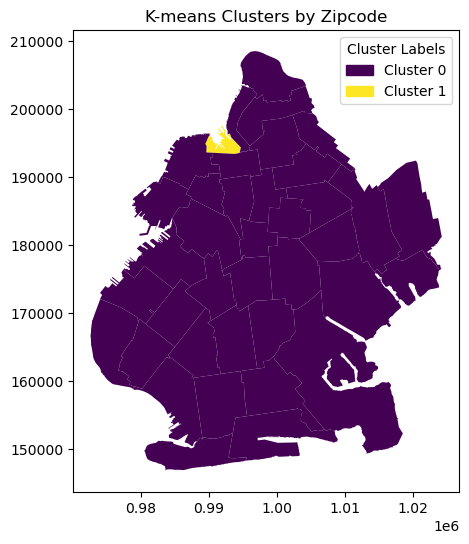

In [14]:
# Create a figure and axis object with a custom size
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

gdf_km.plot(column='cluster', ax=ax, cmap='viridis', legend=False, edgecolor='none')

cmap = plt.cm.viridis
# Normalize the cluster labels to match the color map
norm = Normalize(vmin=gdf_km['cluster'].min(), vmax=gdf_km['cluster'].max())

# Create a list of patches for the legend, representing each cluster
legend_patches = [Patch(color=cmap(norm(value)), label=f'Cluster {value}')
for value in range(int(gdf_km['cluster'].min()), int(gdf_km['cluster'].max()) + 1)]

plt.legend(handles=legend_patches, title="Cluster Labels", loc='upper right')
plt.title('K-means Clusters by Zipcode')
plt.grid(False)
plt.show()

### Gaussian mixture

In [15]:
range_n_clusters = range(2, 11)
silhouettes_gmm = []

for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    gmm.fit(features_scaled)
    # Predict the cluster labels for each data point
    cluster_labels = gmm.predict(features_scaled)
    # Calculate the average silhouette score for this number of clusters
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouettes_gmm.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

best_k_gmm = range_n_clusters[silhouettes_gmm.index(max(silhouettes_gmm))]
print(f"Best number of clusters for GMM: {best_k_gmm}")

For n_clusters = 2, the average silhouette_score is: 0.26296380183545226
For n_clusters = 3, the average silhouette_score is: 0.2369708196284519
For n_clusters = 4, the average silhouette_score is: 0.2544002623771709
For n_clusters = 5, the average silhouette_score is: 0.23867268515136764
For n_clusters = 6, the average silhouette_score is: 0.23859527045222537
For n_clusters = 7, the average silhouette_score is: 0.2688787966518347
For n_clusters = 8, the average silhouette_score is: 0.267019136801288
For n_clusters = 9, the average silhouette_score is: 0.21823395484379107
For n_clusters = 10, the average silhouette_score is: 0.22408109538781268
Best number of clusters for GMM: 7


In [16]:
# Use the existing GeoDataFrame if already defined, otherwise create it
gdf_gmm = gpd.GeoDataFrame(df, geometry='geometry')

# Fit GMM with the best number of clusters found
gmm = GaussianMixture(n_components=best_k_gmm, covariance_type='full', random_state=0)
gmm.fit(features_scaled)
gdf_gmm['cluster'] = gmm.predict(features_scaled)

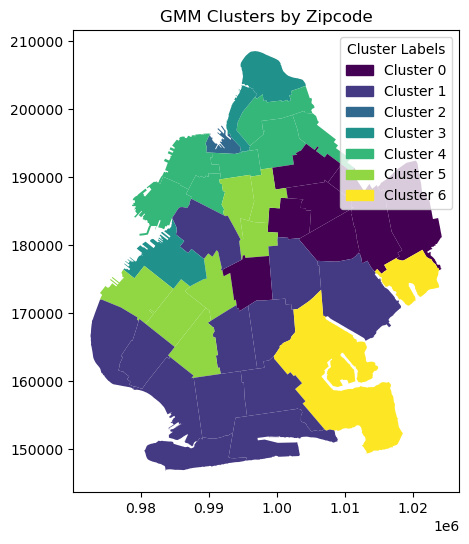

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
gdf_gmm.plot(column='cluster', ax=ax, cmap='viridis', legend=False, edgecolor='none') # Turn off default legend

# Create custom legend
cmap = plt.cm.viridis
norm = Normalize(vmin=gdf_gmm['cluster'].min(), vmax=gdf_gmm['cluster'].max())
legend_patches = [Patch(color=cmap(norm(value)), label=f'Cluster {value}') 
for value in range(int(gdf_gmm['cluster'].min()), int(gdf_gmm['cluster'].max()) + 1)]

plt.legend(handles=legend_patches, title="Cluster Labels")
plt.title('GMM Clusters by Zipcode')
plt.grid(False)
plt.show()

## Bayesian Network

In [18]:
bn_features = ['zipcode','light_density_mile', 'business_ratio', 'public_ratio', 'residential_ratio', 'sidewalk_length', 
               'sidewalk_density', 'street_pos_ratio', 'street_poor_ratio', 'street_nr_ratio', 'arrest_count', 'pop_dens_mile']

In [19]:
# Structure learning
hc = HillClimbSearch(df[bn_features])
best_model = hc.estimate()
print("Best model structure:", best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Best model structure: [('zipcode', 'public_ratio'), ('zipcode', 'street_pos_ratio'), ('light_density_mile', 'arrest_count'), ('light_density_mile', 'zipcode'), ('light_density_mile', 'sidewalk_density'), ('light_density_mile', 'pop_dens_mile'), ('business_ratio', 'public_ratio'), ('business_ratio', 'zipcode'), ('business_ratio', 'street_pos_ratio'), ('business_ratio', 'sidewalk_density'), ('business_ratio', 'pop_dens_mile'), ('business_ratio', 'light_density_mile'), ('business_ratio', 'sidewalk_length'), ('business_ratio', 'residential_ratio'), ('public_ratio', 'arrest_count'), ('residential_ratio', 'arrest_count'), ('residential_ratio', 'zipcode'), ('residential_ratio', 'street_pos_ratio'), ('residential_ratio', 'sidewalk_density'), ('residential_ratio', 'pop_dens_mile'), ('residential_ratio', 'light_density_mile'), ('residential_ratio', 'sidewalk_length'), ('sidewalk_length', 'zipcode'), ('sidewalk_length', 'sidewalk_density'), ('sidewalk_length', 'pop_dens_mile'), ('sidewalk_length'

In [20]:
for edge in best_model.edges():
    print(edge)

('zipcode', 'public_ratio')
('zipcode', 'street_pos_ratio')
('light_density_mile', 'arrest_count')
('light_density_mile', 'zipcode')
('light_density_mile', 'sidewalk_density')
('light_density_mile', 'pop_dens_mile')
('business_ratio', 'public_ratio')
('business_ratio', 'zipcode')
('business_ratio', 'street_pos_ratio')
('business_ratio', 'sidewalk_density')
('business_ratio', 'pop_dens_mile')
('business_ratio', 'light_density_mile')
('business_ratio', 'sidewalk_length')
('business_ratio', 'residential_ratio')
('public_ratio', 'arrest_count')
('residential_ratio', 'arrest_count')
('residential_ratio', 'zipcode')
('residential_ratio', 'street_pos_ratio')
('residential_ratio', 'sidewalk_density')
('residential_ratio', 'pop_dens_mile')
('residential_ratio', 'light_density_mile')
('residential_ratio', 'sidewalk_length')
('sidewalk_length', 'zipcode')
('sidewalk_length', 'sidewalk_density')
('sidewalk_length', 'pop_dens_mile')
('sidewalk_length', 'light_density_mile')
('sidewalk_density', 'pu

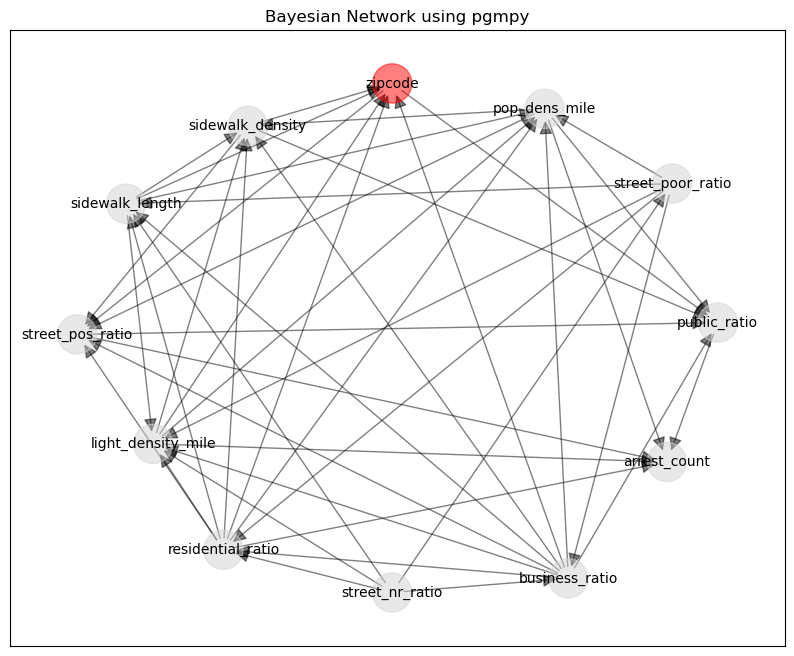

In [21]:
G = nx.DiGraph()
G.add_edges_from(best_model.edges())
pos = nx.spring_layout(G, k=30, seed=20) # k: optimal distance between nodes

highlightedNodes = {'zipcode'}

node_colors = ['red' if node in highlightedNodes else 'lightgrey' for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos=pos, arrowstyle='-|>', arrowsize=20, edge_color='k', alpha=0.5)
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=800, alpha=0.5)
nx.draw_networkx_labels(G, pos=pos, font_size=10)

plt.title('Bayesian Network using pgmpy')
plt.savefig("../../results/bn_pgmpy.png", dpi=300, bbox_inches='tight')
plt.show()

## Social Demographic

In [22]:
social_demo = df.loc[:, ['zipcode'] + list(df.loc[:, 'households_num':'total_62+'].columns)]
sd_analysis = gdf_gmm[['zipcode', 'cluster']].merge(social_demo, on='zipcode', how='left')

print(sd_analysis[sd_analysis.isna().any(axis=1)])
sd_analysis = sd_analysis.dropna()

sd_analysis['households_num'] = sd_analysis['households_num'].astype(int)

    zipcode  cluster households_num  pop_num  25+bh  total_noninsti_dis  \
12    11251        2            NaN        0      0                   0   

    total_commute16+  commute_pub_16+  commute_walk_16+  med_hh_inc  \
12                 0                0                 0         NaN   

    mean_hh_inc  per_cap_inc  total_62+  
12          NaN          NaN          0  


In [23]:
sd_analysis['area_mile'] = df['area_mile']

In [24]:
sd_analysis

,zipcode,cluster,households_num,pop_num,25+bh,total_noninsti_dis,total_commute16+,commute_pub_16+,commute_walk_16+,med_hh_inc,mean_hh_inc,per_cap_inc,total_62+,area_mile
0,11213,0,26281,67382,14638,8571,29101,16600,2723,54211.0,84408.0,32775.0,11155,1.062866
1,11212,0,32091,77485,9109,12591,29233,19090,1851,35840.0,53831.0,21502.0,15580,1.505542
2,11225,5,24873,58082,20399,5582,30607,17763,1612,82716.0,107973.0,46442.0,10779,0.850071
3,11218,5,26048,72420,24225,6676,33549,15379,3125,87759.0,138411.0,49052.0,12174,1.322486
4,11226,0,38458,99459,25692,6733,52014,34323,2207,75947.0,99788.0,39023.0,16203,1.413589
5,11219,5,24031,91131,9577,6259,30811,10420,8574,51194.0,77462.0,20336.0,12970,1.506641
6,11210,1,21652,63051,16724,6836,27595,13772,1513,82904.0,114070.0,39710.0,12673,1.717711
7,11230,1,31897,89313,25207,11708,36656,15770,4060,65051.0,95988.0,33980.0,18883,1.790874
8,11204,5,25118,80301,15223,6710,31103,13156,4499,64172.0,83981.0,25404.0,14287,1.562327
9,11222,3,19108,39681,21231,2864,25584,12064,2212,126250.0,153168.0,72001.0,4998,1.536146


In [25]:
zipcode_cluster = sd_analysis.groupby('cluster')['zipcode'].unique().reset_index()
zipcode_cluster['zipcode'] = zipcode_cluster['zipcode'].apply(lambda x: ', '.join(map(str, x)))
for clus in range(len(zipcode_cluster)):
    print(f'Cluster {clus}:')
    for zipcode in zipcode_cluster[zipcode_cluster.cluster == clus].zipcode.tolist():
        print('with zipcode:')
        print(zipcode)
        print()

Cluster 0:
with zipcode:
11213, 11212, 11226, 11208, 11207, 11221, 11233

Cluster 1:
with zipcode:
11210, 11230, 11215, 11203, 11236, 11209, 11228, 11229, 11214, 11223, 11235, 11224

Cluster 2:
Cluster 3:
with zipcode:
11222, 11232, 11249

Cluster 4:
with zipcode:
11237, 11206, 11201, 11205, 11217, 11231, 11211

Cluster 5:
with zipcode:
11225, 11218, 11219, 11204, 11238, 11220, 11216



In [26]:
sd_analysis.shape

(38, 14)

In [27]:
sd_analysis.dtypes

zipcode                 int32
cluster                 int64
households_num          int32
pop_num                 int32
25+bh                   int32
total_noninsti_dis      int32
total_commute16+        int32
commute_pub_16+         int32
commute_walk_16+        int32
med_hh_inc            float64
mean_hh_inc           float64
per_cap_inc           float64
total_62+               int32
area_mile             float64
dtype: object

In [28]:
sd_analysis['total_hh_inc'] = sd_analysis.households_num * sd_analysis.mean_hh_inc
sd_analysis['total_cap_inc'] = sd_analysis.pop_num * sd_analysis.per_cap_inc

agg_sd = sd_analysis.groupby('cluster').agg({
    'households_num': 'sum', 
    'pop_num':'sum',
    '25+bh': 'sum',
    'total_noninsti_dis': 'sum', 
    'total_commute16+': 'sum',
    'commute_pub_16+': 'sum',
    'commute_walk_16+': 'sum',
    'med_hh_inc': 'median',
    'total_hh_inc': 'sum',
    'total_cap_inc':'sum',
    'total_62+': 'sum',
    'area_mile': 'sum'
}).reset_index()

agg_sd['clus_mean_hh_inc'] = agg_sd.total_hh_inc / agg_sd.households_num
agg_sd['clus_mean_perCap_inc'] = agg_sd.total_cap_inc / agg_sd.pop_num

In [29]:
agg_sd.head(3)

,cluster,households_num,pop_num,25+bh,total_noninsti_dis,total_commute16+,commute_pub_16+,commute_walk_16+,med_hh_inc,total_hh_inc,total_cap_inc,total_62+,area_mile,clus_mean_hh_inc,clus_mean_perCap_inc
0,0,233743,615442,117345,69157,277592,166565,13992,56298.0,1.932268e+10,1.934433e+10,99880,12.222144,82666.329328,31431.602200
1,1,335184,892534,264875,99844,395458,186721,30910,70402.5,3.728634e+10,3.742556e+10,202437,25.617155,111241.401738,41931.808625
2,3,45744,110762,44436,8780,62360,30030,6262,113946.0,6.975300e+09,6.867922e+09,11804,4.178022,152485.581475,62006.119689


In [30]:
agg_sd

,cluster,households_num,pop_num,25+bh,total_noninsti_dis,total_commute16+,commute_pub_16+,commute_walk_16+,med_hh_inc,total_hh_inc,total_cap_inc,total_62+,area_mile,clus_mean_hh_inc,clus_mean_perCap_inc
0,0,233743,615442,117345,69157,277592,166565,13992,56298.0,1.932268e+10,1.934433e+10,99880,12.222144,82666.329328,31431.602200
1,1,335184,892534,264875,99844,395458,186721,30910,70402.5,3.728634e+10,3.742556e+10,202437,25.617155,111241.401738,41931.808625
2,3,45744,110762,44436,8780,62360,30030,6262,113946.0,6.975300e+09,6.867922e+09,11804,4.178022,152485.581475,62006.119689
3,4,161531,393913,154456,38198,204717,104366,23575,94824.0,2.544725e+10,2.507748e+10,49752,8.393249,157537.865103,63662.476125
4,5,180780,512866,143502,44443,236085,113652,27702,82716.0,2.058220e+10,2.037069e+10,81432,8.949107,113852.188843,39719.314336
5,6,40973,106182,27108,13259,46582,18893,1717,65024.5,4.454012e+09,4.505338e+09,27291,8.895622,108706.035926,42430.337571


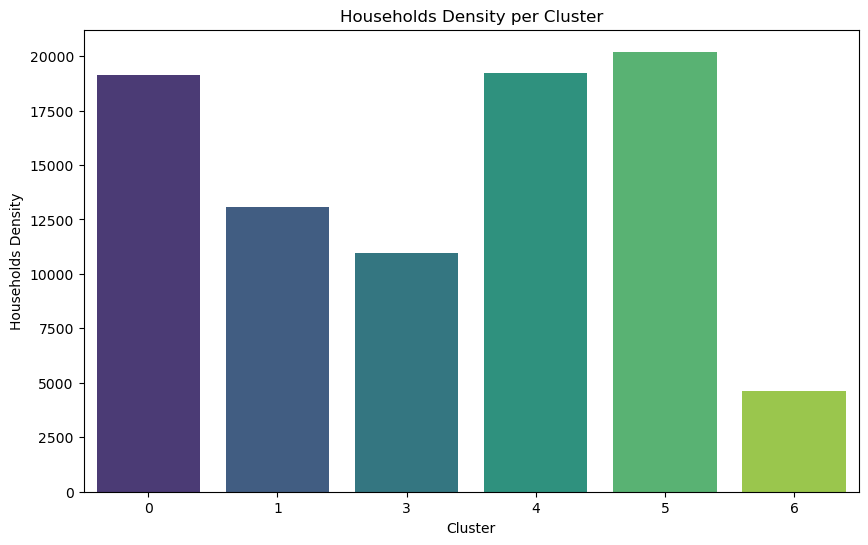

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['households_num']/agg_sd['area_mile'], palette='viridis')
plt.title('Households Density per Cluster')
plt.ylabel('Households Density')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/hh_num.png", dpi=300, bbox_inches='tight')
plt.show()

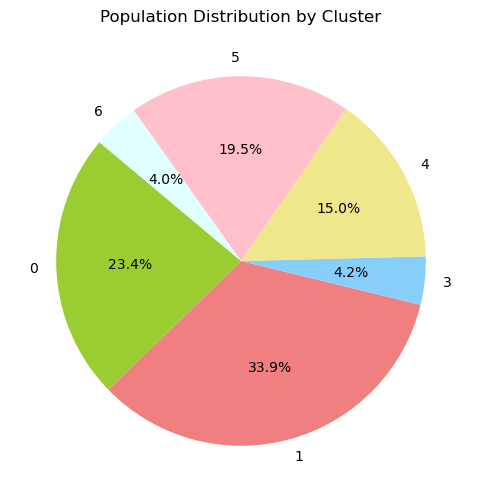

In [32]:
pop_by_cluster = agg_sd.groupby('cluster')['pop_num'].sum()
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'khaki', 'pink', 'lightcyan']
plt.figure(figsize=(10, 6))
plt.pie(pop_by_cluster, labels=pop_by_cluster.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Population Distribution by Cluster')
plt.savefig("../../results/population_distribution_by_cluster.png", dpi=300, bbox_inches='tight')
plt.show()

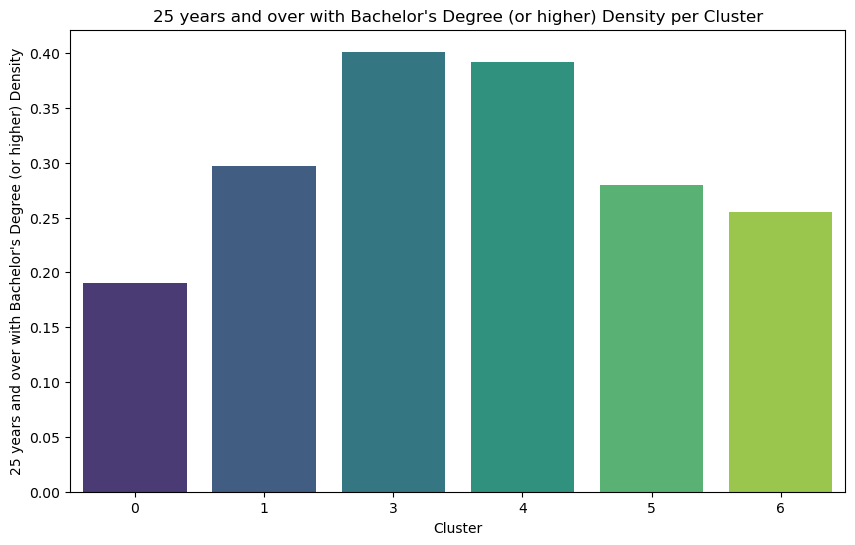

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['25+bh']/agg_sd['pop_num'], palette='viridis')
plt.title('25 years and over with Bachelor\'s Degree (or higher) Density per Cluster')
plt.ylabel('25 years and over with Bachelor\'s Degree (or higher) Density')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/bh_num.png", dpi=300, bbox_inches='tight')
plt.show()

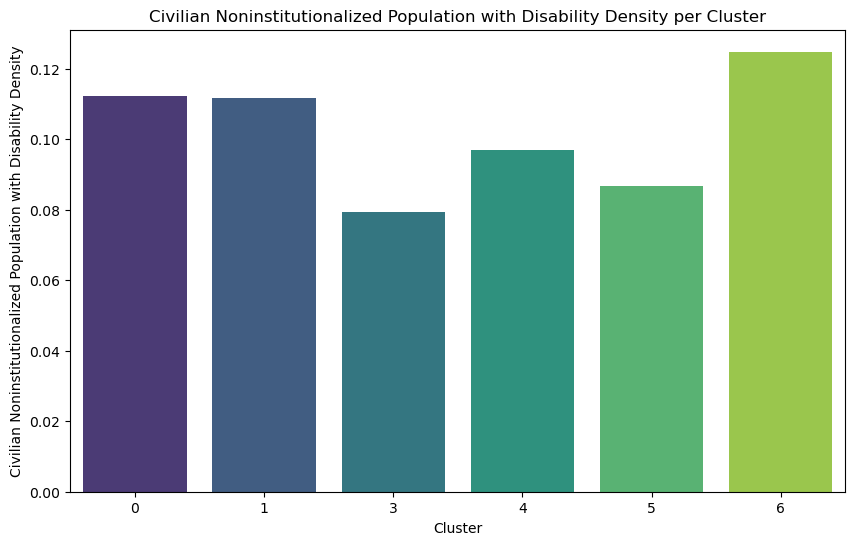

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['total_noninsti_dis']/agg_sd['pop_num'], palette='viridis')
plt.title('Civilian Noninstitutionalized Population with Disability Density per Cluster')
plt.ylabel('Civilian Noninstitutionalized Population with Disability Density')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/dis_num.png", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
agg_sd.columns

Index(['cluster', 'households_num', 'pop_num', '25+bh', 'total_noninsti_dis',
       'total_commute16+', 'commute_pub_16+', 'commute_walk_16+', 'med_hh_inc',
       'total_hh_inc', 'total_cap_inc', 'total_62+', 'area_mile',
       'clus_mean_hh_inc', 'clus_mean_perCap_inc'],
      dtype='object')

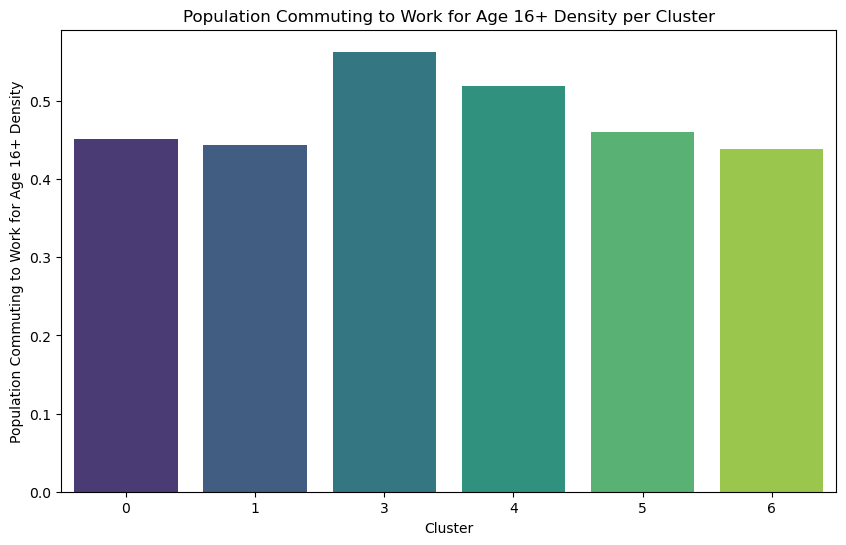

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['total_commute16+']/agg_sd['pop_num'], palette='viridis')
plt.title('Population Commuting to Work for Age 16+ Density per Cluster')
plt.ylabel('Population Commuting to Work for Age 16+ Density')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/com_num.png", dpi=300, bbox_inches='tight')
plt.show()

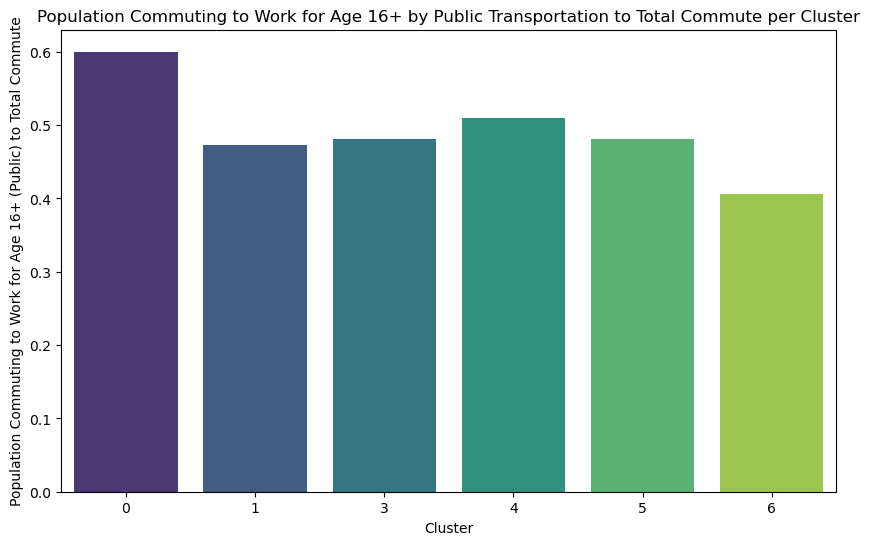

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['commute_pub_16+']/agg_sd['total_commute16+'], palette='viridis')
plt.title('Population Commuting to Work for Age 16+ by Public Transportation to Total Commute per Cluster')
plt.ylabel('Population Commuting to Work for Age 16+ (Public) to Total Commute')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/commute_pub_16+.png", dpi=300, bbox_inches='tight')
plt.show()

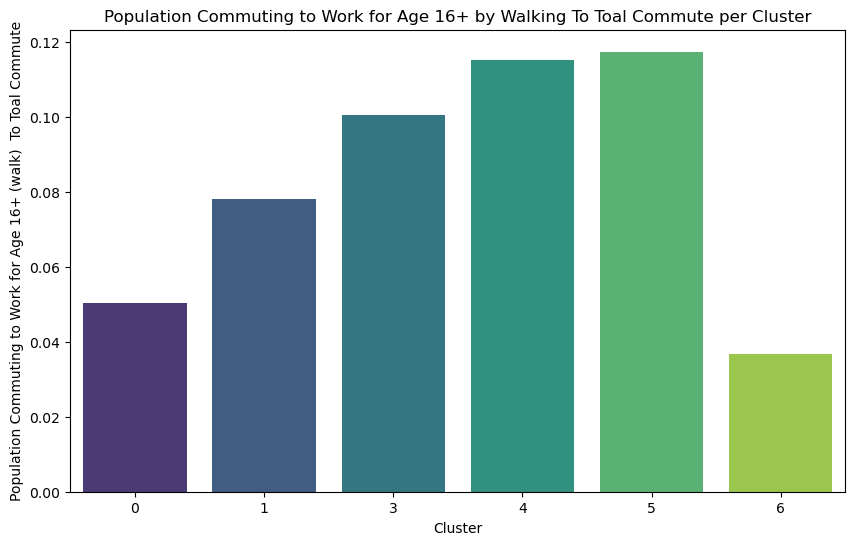

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['commute_walk_16+']/agg_sd['total_commute16+'], palette='viridis')
plt.title('Population Commuting to Work for Age 16+ by Walking To Toal Commute per Cluster')
plt.ylabel('Population Commuting to Work for Age 16+ (walk)  To Toal Commute')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/commute_walk_16+.png", dpi=300, bbox_inches='tight')
plt.show()

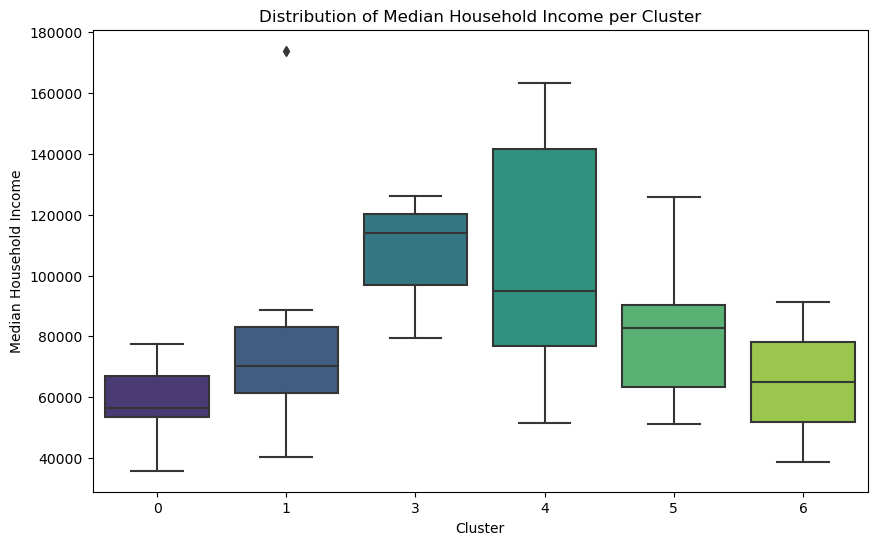

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='med_hh_inc', data=sd_analysis, palette='viridis')
plt.title('Distribution of Median Household Income per Cluster')
plt.ylabel('Median Household Income')
plt.xlabel('Cluster')
plt.savefig("../../results/med_hh_inc_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

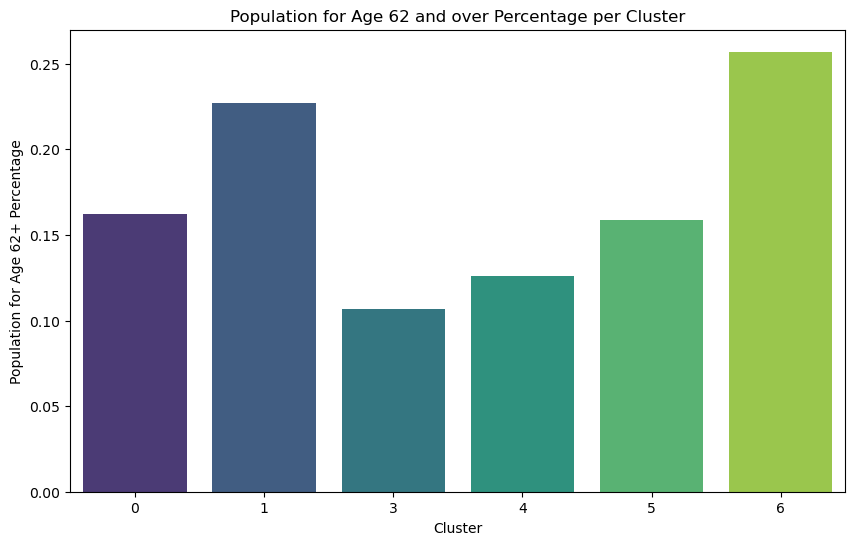

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['total_62+']/agg_sd['pop_num'], palette='viridis')
plt.title('Population for Age 62 and over Percentage per Cluster')
plt.ylabel('Population for Age 62+ Percentage')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/total_62+.png", dpi=300, bbox_inches='tight')
plt.show()

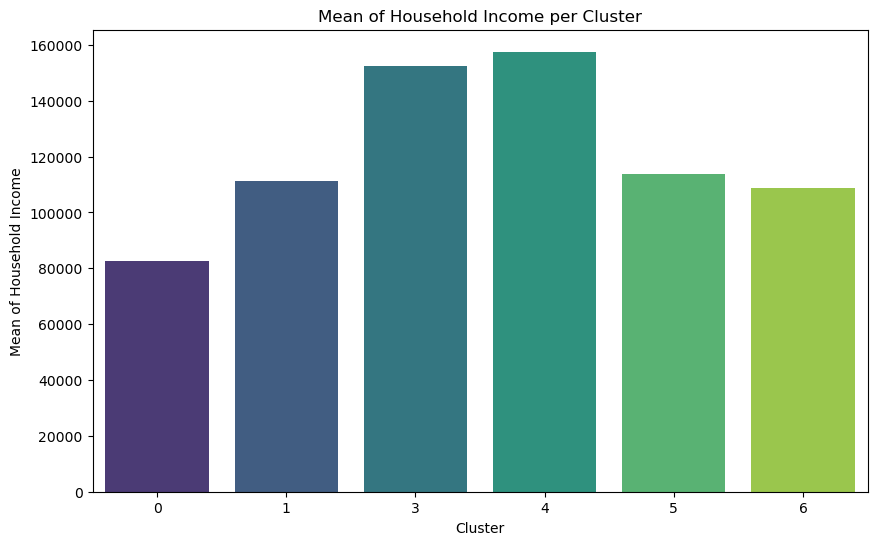

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['clus_mean_hh_inc'], palette='viridis')
plt.title('Mean of Household Income per Cluster')
plt.ylabel('Mean of Household Income')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/clus_mean_hh_inc.png", dpi=300, bbox_inches='tight')
plt.show()

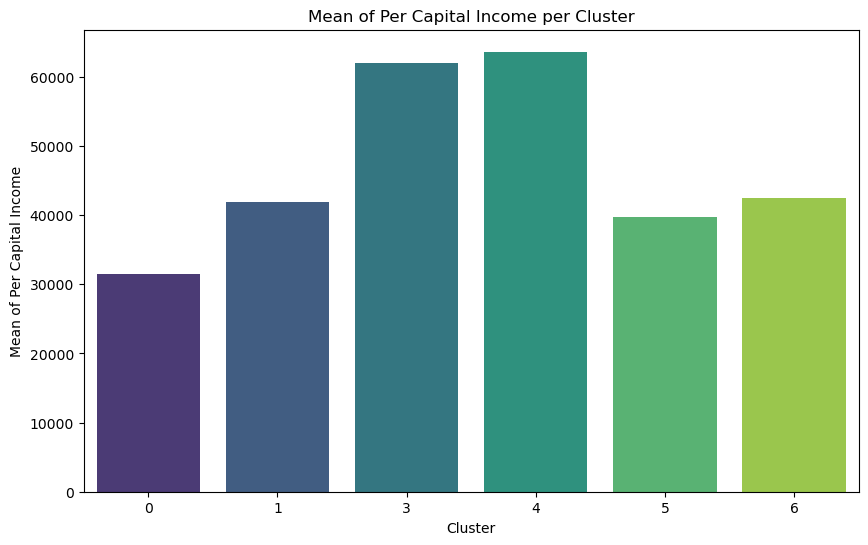

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x=agg_sd['cluster'], y=agg_sd['clus_mean_perCap_inc'], palette='viridis')
plt.title('Mean of Per Capital Income per Cluster')
plt.ylabel('Mean of Per Capital Income')
plt.xlabel('Cluster')
plt.xticks(range(len(agg_sd)))
plt.savefig("../../results/clus_mean_perCap_inc.png", dpi=300, bbox_inches='tight')
plt.show()